АНАЛИЗ ПРОЕКТНЫХ ДАННЫХ ИЗ CSV ФАЙЛА

1. ВЫБОР ФАЙЛА:
--------------------------------------------------
Выбран файл: C:/Users/edu-msk22-803s/Downloads/NEW_GANTT_VER/DATA.csv

2. ЧТЕНИЕ ДАННЫХ ИЗ ФАЙЛА:
--------------------------------------------------
Прочитано 15 работ

3. ВАЛИДАЦИЯ ДАННЫХ ИЗ CSV:
--------------------------------------------------
✓ Данные CSV прошли валидацию успешно

4. ВАЛИДАЦИЯ ЗАВИСИМОСТЕЙ:
--------------------------------------------------
Начальные работы: A, J
Конечные работы: N, O
✓ Зависимости прошли валидацию успешно

5. РАСЧЕТ КРИТИЧЕСКОГО ПУТИ:
--------------------------------------------------
Критический путь: A → B → E → G → H → K → M → N
Длина критического пути: 42.0 дней

6. РАСПИСАНИЕ РАБОТ:
--------------------------------------------------
Работа Начало   Окончание  Длит.  Резерв   Критич. 
------------------------------------------------------------
A     0.0      3.0        3.0    0.0      Да      
B     3.0      14.0       11.0   0.0      Да 

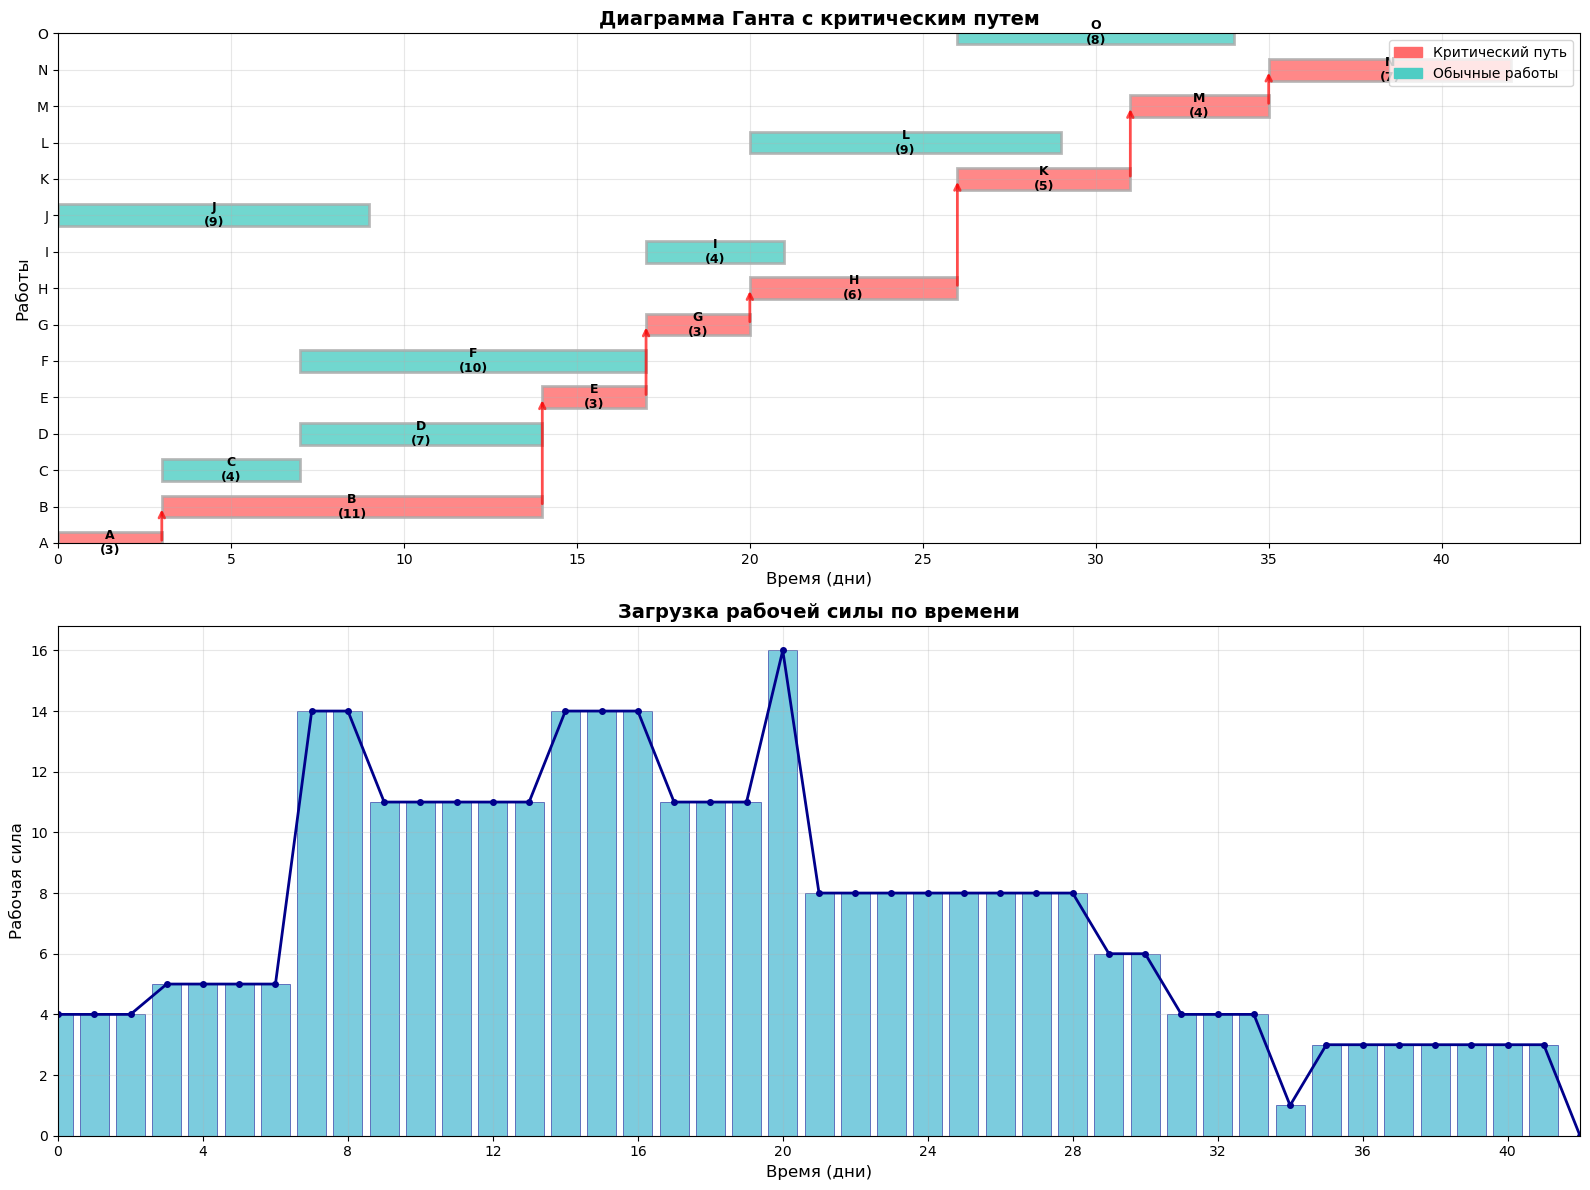


8. ДОПОЛНИТЕЛЬНАЯ ИНФОРМАЦИЯ:
--------------------------------------------------
Общая продолжительность проекта: 42.0 дней
Общая требуемая рабочая сила: 53.0 человеко-дней
Максимальная одновременная загрузка: 16.0 человек
Количество критических работ: 8
Количество обычных работ: 7


In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import networkx as nx
import numpy as np
import csv
import os
from tkinter import Tk, filedialog

def read_project_data(csv_file_path):
    """
    Чтение данных проекта из CSV файла с детальной обработкой ошибок
    """
    data = []
    line_errors = []
    
    with open(csv_file_path, 'r', encoding='utf-8') as file:
        reader = csv.reader(file)
        for line_num, row in enumerate(reader, 1):
            if len(row) == 0:  # Пропускаем пустые строки
                continue
                
            if len(row) < 5:  # Минимум 5 колонок
                line_errors.append(f"Строка {line_num}: Недостаточно колонок (ожидается 5, получено {len(row)})")
                continue
            
            # Обработка строки - все пустые ячейки заменяем на '-'
            work = row[0].strip() if len(row) > 0 and row[0].strip() != '' else '-'
            followers = row[1].strip() if len(row) > 1 and row[1].strip() != '' else '-'
            predecessors = row[2].strip() if len(row) > 2 and row[2].strip() != '' else '-'
            duration = row[3].strip() if len(row) > 3 and row[3].strip() != '' else '-'
            workforce = row[4].strip() if len(row) > 4 and row[4].strip() != '' else '-'
            
            # Замена символов для единообразия
            followers = followers.replace(';', ',')
            predecessors = predecessors.replace(';', ',')
            
            data.append({
                'Работа': work,
                'Последователи': followers,
                'Предшественники': predecessors,
                'Продолжительность': duration,
                'Рабочая сила': workforce,
                'ИсходнаяСтрока': line_num  # Сохраняем номер строки для отслеживания ошибок
            })
    
    df = pd.DataFrame(data)
    
    # Преобразование числовых колонок с детальной обработкой ошибок
    numeric_errors = []
    
    for idx, row in df.iterrows():
        line_num = row['ИсходнаяСтрока']
        
        # Проверка продолжительности
        duration_str = str(row['Продолжительность'])
        if duration_str != '-':
            try:
                duration_val = float(duration_str)
                df.at[idx, 'Продолжительность'] = duration_val
            except ValueError:
                numeric_errors.append(f"Строка {line_num}, колонка 'Продолжительность': Некорректное числовое значение '{duration_str}'")
                df.at[idx, 'Продолжительность'] = np.nan
        
        # Проверка рабочей силы
        workforce_str = str(row['Рабочая сила'])
        if workforce_str != '-':
            try:
                workforce_val = float(workforce_str)
                df.at[idx, 'Рабочая сила'] = workforce_val
            except ValueError:
                numeric_errors.append(f"Строка {line_num}, колонка 'Рабочая сила': Некорректное числовое значение '{workforce_str}'")
                df.at[idx, 'Рабочая сила'] = np.nan
    
    return df, line_errors + numeric_errors

def validate_csv_data(df):
    """
    Валидация входных данных из CSV файла с детальным выводом ошибок
    """
    errors = []
    
    # Проверка наличия обязательных колонок
    required_columns = ['Работа', 'Последователи', 'Предшественники', 'Продолжительность', 'Рабочая сила']
    for col in required_columns:
        if col not in df.columns:
            errors.append(f"Отсутствует обязательная колонка: {col}")
    
    if errors:
        return False, errors
    
    # Проверка типов данных и значений
    for idx, row in df.iterrows():
        line_num = row['ИсходнаяСтрока']
        work = row['Работа']
        
        # Проверка идентификатора работы
        if work == '-':
            errors.append(f"Строка {line_num}, колонка 'Работа': Идентификатор работы не может быть '-'")
        
        # Проверка продолжительности
        if pd.isna(row['Продолжительность']):
            errors.append(f"Строка {line_num}, колонка 'Продолжительность': Отсутствует числовое значение")
        else:
            duration = row['Продолжительность']
            if not isinstance(duration, (int, float)):
                errors.append(f"Строка {line_num}, колонка 'Продолжительность': Некорректный тип данных '{type(duration).__name__}'")
            elif duration <= 0:
                errors.append(f"Строка {line_num}, колонка 'Продолжительность': Продолжительность должна быть положительной (получено {duration})")
        
        # Проверка рабочей силы
        if pd.isna(row['Рабочая сила']):
            errors.append(f"Строка {line_num}, колонка 'Рабочая сила': Отсутствует числовое значение")
        else:
            workforce = row['Рабочая сила']
            if not isinstance(workforce, (int, float)):
                errors.append(f"Строка {line_num}, колонка 'Рабочая сила': Некорректный тип данных '{type(workforce).__name__}'")
            elif workforce < 0:
                errors.append(f"Строка {line_num}, колонка 'Рабочая сила': Рабочая сила не может быть отрицательной (получено {workforce})")
        
        # Проверка формата последователей
        if pd.notna(row['Последователи']) and row['Последователи'] != '' and row['Последователи'] != '-':
            followers = str(row['Последователи']).split(',')
            for i, follower in enumerate(followers):
                follower_clean = follower.strip()
                if follower_clean and follower_clean != '-':
                    if not follower_clean.replace(' ', '').isalnum():
                        errors.append(f"Строка {line_num}, колонка 'Последователи': Некорректный формат идентификатора '{follower}' (позиция {i+1})")
        
        # Проверка формата предшественников
        if pd.notna(row['Предшественники']) and row['Предшественники'] != '' and row['Предшественники'] != '-':
            predecessors = str(row['Предшественники']).split(',')
            for i, predecessor in enumerate(predecessors):
                predecessor_clean = predecessor.strip()
                if predecessor_clean and predecessor_clean != '-':
                    if not predecessor_clean.replace(' ', '').isalnum():
                        errors.append(f"Строка {line_num}, колонка 'Предшественники': Некорректный формат идентификатора '{predecessor}' (позиция {i+1})")
    
    # Проверка уникальности идентификаторов работ
    duplicate_works = df[df['Работа'].duplicated()]['Работа'].unique()
    for work in duplicate_works:
        duplicate_lines = df[df['Работа'] == work]['ИсходнаяСтрока'].tolist()
        errors.append(f"Дублирование идентификатора работы '{work}' в строках: {', '.join(map(str, duplicate_lines))}")
    
    return len(errors) == 0, errors

def validate_dependencies(df):
    """
    Проверка связанности и корректности зависимостей с детальным выводом ошибок
    """
    errors = []
    warnings = []
    
    # Создаем граф зависимостей
    G = nx.DiGraph()
    
    # Добавляем узлы (работы)
    for work in df['Работа']:
        G.add_node(work)
    
    # Добавляем рёбра (зависимости) с отслеживанием строк
    edge_sources = {}  # Для отслеживания, откуда взялась зависимость
    
    for idx, row in df.iterrows():
        line_num = row['ИсходнаяСтрока']
        work = row['Работа']
        
        # Обрабатываем предшественников
        if pd.notna(row['Предшественники']) and row['Предшественники'] != '' and row['Предшественники'] != '-':
            predecessors = str(row['Предшественники']).split(',')
            for pred in predecessors:
                pred_clean = pred.strip()
                if pred_clean and pred_clean != '-':
                    if pred_clean not in G.nodes:
                        errors.append(f"Строка {line_num}: Предшественник '{pred_clean}' для работы '{work}' не существует")
                    else:
                        G.add_edge(pred_clean, work)
                        edge_sources[(pred_clean, work)] = f"строка {line_num}"
        
        # Обрабатываем последователей
        if pd.notna(row['Последователи']) and row['Последователи'] != '' and row['Последователи'] != '-':
            followers = str(row['Последователи']).split(',')
            for follower in followers:
                follower_clean = follower.strip()
                if follower_clean and follower_clean != '-':
                    if follower_clean not in G.nodes:
                        errors.append(f"Строка {line_num}: Последователь '{follower_clean}' для работы '{work}' не существует")
                    else:
                        G.add_edge(work, follower_clean)
                        edge_sources[(work, follower_clean)] = f"строка {line_num}"
    
    # Проверка на циклы
    try:
        cycles = list(nx.simple_cycles(G))
        for cycle in cycles:
            cycle_info = []
            for i in range(len(cycle)):
                from_node = cycle[i]
                to_node = cycle[(i + 1) % len(cycle)]
                source = edge_sources.get((from_node, to_node), "неизвестный источник")
                cycle_info.append(f"{from_node}->{to_node} ({source})")
            errors.append(f"Обнаружена циклическая зависимость: {' -> '.join(cycle)}. Зависимости: {', '.join(cycle_info)}")
    except Exception as e:
        errors.append(f"Ошибка при проверке циклов: {e}")
    
    # Проверка на самозависимости
    for node in G.nodes:
        if G.has_edge(node, node):
            source = edge_sources.get((node, node), "неизвестный источник")
            errors.append(f"Работа '{node}' зависит от самой себя ({source})")
    
    # Проверка связности графа
    if not nx.is_weakly_connected(G):
        components = list(nx.weakly_connected_components(G))
        component_info = []
        for i, component in enumerate(components, 1):
            component_info.append(f"Компонент {i}: {', '.join(sorted(component))}")
        warnings.append(f"Граф не является слабосвязным. Обнаружено {len(components)} компонент связности:\n" + "\n".join(component_info))
    
    # Проверка наличия начальных работ (без предшественников)
    start_nodes = [node for node in G.nodes if G.in_degree(node) == 0]
    if not start_nodes:
        errors.append("Не найдено начальных работ (без предшественников)")
    else:
        print(f"Начальные работы: {', '.join(sorted(start_nodes))}")
    
    # Проверка наличия конечных работ (без последователей)
    end_nodes = [node for node in G.nodes if G.out_degree(node) == 0]
    if not end_nodes:
        errors.append("Не найдено конечных работ (без последователей)")
    else:
        print(f"Конечные работы: {', '.join(sorted(end_nodes))}")
    
    return len(errors) == 0, errors, warnings, G

def calculate_critical_path(df, G):
    """
    Расчет критического пути
    """
    # Расчет ранних сроков
    early_start = {}
    early_finish = {}
    
    # Топологическая сортировка
    try:
        topological_order = list(nx.topological_sort(G))
    except nx.NetworkXUnfeasible:
        print("Ошибка: граф содержит циклы, невозможно рассчитать критический путь")
        return None, None, None, None
    
    # Инициализация начальных работ
    for node in topological_order:
        if G.in_degree(node) == 0:  # Начальная работа
            early_start[node] = 0
        else:
            early_start[node] = 0
    
    # Расчет ранних сроков (прямой проход)
    for node in topological_order:
        duration = df[df['Работа'] == node]['Продолжительность'].values[0]
        
        # Максимальный ранний финиш среди предшественников
        max_pred_finish = 0
        for pred in G.predecessors(node):
            if pred in early_finish and early_finish[pred] > max_pred_finish:
                max_pred_finish = early_finish[pred]
        
        early_start[node] = max_pred_finish
        early_finish[node] = early_start[node] + duration
    
    # Расчет поздних сроков
    late_start = {}
    late_finish = {}
    project_duration = max(early_finish.values())
    
    # Инициализация конечных работ
    for node in reversed(topological_order):
        if G.out_degree(node) == 0:  # Конечная работа
            late_finish[node] = project_duration
            late_start[node] = late_finish[node] - df[df['Работа'] == node]['Продолжительность'].values[0]
        else:
            late_finish[node] = project_duration
            late_start[node] = project_duration
    
    # Расчет поздних сроков (обратный проход)
    for node in reversed(topological_order):
        duration = df[df['Работа'] == node]['Продолжительность'].values[0]
        
        # Минимальный поздний старт среди последователей
        min_succ_start = project_duration
        for succ in G.successors(node):
            if succ in late_start and late_start[succ] < min_succ_start:
                min_succ_start = late_start[succ]
        
        late_finish[node] = min_succ_start
        late_start[node] = late_finish[node] - duration
    
    # Расчет резервов и определение критического пути
    critical_path = []
    total_slack = {}
    
    for node in topological_order:
        slack = late_start[node] - early_start[node]
        total_slack[node] = slack
        if abs(slack) < 1e-9:  # Учет погрешности вычислений
            critical_path.append(node)
    
    return early_start, early_finish, critical_path, total_slack

def create_gantt_chart(df, early_start, early_finish, critical_path):
    """
    Создание улучшенной диаграммы Ганта с графиком рабочей силы
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12))
    
    # Цвета
    critical_color = '#ff6b6b'  # Красный для критического пути
    normal_color = '#4ecdc4'    # Бирюзовый для обычных работ
    workforce_color = '#45b7d1' # Синий для рабочей силы
    
    # Сортировка работ для красивого отображения
    sorted_works = sorted(df['Работа'].unique())
    y_positions = range(len(sorted_works))
    
    # Диаграмма Ганта
    for i, work in enumerate(sorted_works):
        start = early_start[work]
        finish = early_finish[work]
        duration = finish - start
        
        # Выбор цвета в зависимости от критичности
        color = critical_color if work in critical_path else normal_color
        
        # Прямоугольник для работы
        rect = patches.Rectangle((start, i-0.3), duration, 0.6, 
                               linewidth=2, edgecolor='darkgray', 
                               facecolor=color, alpha=0.8)
        ax1.add_patch(rect)
        
        # Подпись работы и длительности
        ax1.text(start + duration/2, i, f'{work}\n({int(duration)})', 
                ha='center', va='center', fontweight='bold', fontsize=9)
        
        # Стрелки зависимостей (только для критического пути)
        if work in critical_path:
            predecessors_str = df[df['Работа'] == work]['Предшественники'].values[0]
            if pd.notna(predecessors_str) and predecessors_str != '' and predecessors_str != '-':
                predecessors = str(predecessors_str).split(',')
                for pred_clean in predecessors:
                    pred_clean = pred_clean.strip()
                    if pred_clean and pred_clean in critical_path and pred_clean in early_finish:
                        # Рисуем стрелку от предшественника к текущей работе
                        ax1.annotate('', xy=(start, i), 
                                   xytext=(early_finish[pred_clean], sorted_works.index(pred_clean)),
                                   arrowprops=dict(arrowstyle='->', color='red', lw=2, alpha=0.7))
    
    ax1.set_xlabel('Время (дни)', fontsize=12)
    ax1.set_ylabel('Работы', fontsize=12)
    ax1.set_title('Диаграмма Ганта с критическим путем', fontsize=14, fontweight='bold')
    ax1.set_yticks(y_positions)
    ax1.set_yticklabels(sorted_works)
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(0, max(early_finish.values()) + 2)
    
    # Легенда
    critical_patch = patches.Patch(color=critical_color, label='Критический путь')
    normal_patch = patches.Patch(color=normal_color, label='Обычные работы')
    ax1.legend(handles=[critical_patch, normal_patch], loc='upper right')
    
    # График загрузки рабочей силы
    project_duration = int(max(early_finish.values()))
    workforce_over_time = [0] * (project_duration + 2)  # +2 для запаса
    
    for work in sorted_works:
        start = int(early_start[work])
        finish = int(early_finish[work])
        workforce = df[df['Работа'] == work]['Рабочая сила'].values[0]
        
        for day in range(start, finish):
            if day < len(workforce_over_time):
                workforce_over_time[day] += workforce
    
    # Создание графика рабочей силы
    days = range(project_duration + 1)
    workforce_values = workforce_over_time[:project_duration + 1]
    
    ax2.bar(days, workforce_values, color=workforce_color, alpha=0.7, edgecolor='darkblue', linewidth=0.5)
    ax2.plot(days, workforce_values, color='darkblue', linewidth=2, marker='o', markersize=4)
    
    ax2.set_xlabel('Время (дни)', fontsize=12)
    ax2.set_ylabel('Рабочая сила', fontsize=12)
    ax2.set_title('Загрузка рабочей силы по времени', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.set_xticks(range(0, project_duration + 1, max(1, project_duration // 10)))
    ax2.set_xlim(0, project_duration)
    
    plt.tight_layout()
    plt.show()
    
    return fig

def calculate_workforce_stats(df, early_start, early_finish, total_duration):
    """
    Расчет статистики по рабочей силе
    """
    max_workforce = 0
    for day in range(int(total_duration) + 1):
        daily_workforce = 0
        for work in df['Работа']:
            start = early_start[work]
            finish = early_finish[work]
            if start <= day < finish:
                workforce = df[df['Работа'] == work]['Рабочая сила'].values[0]
                daily_workforce += workforce
        if daily_workforce > max_workforce:
            max_workforce = daily_workforce
    
    return max_workforce

def select_csv_file():
    """
    Диалоговое окно для выбора CSV файла
    """
    root = Tk()
    root.withdraw()
    file_path = filedialog.askopenfilename(
        title="Выберите CSV файл с данными проекта",
        filetypes=[("CSV files", "*.csv"), ("All files", "*.*")]
    )
    root.destroy()
    return file_path

def main():
    """
    Основная функция для демонстрации работы
    """
    print("=" * 70)
    print("АНАЛИЗ ПРОЕКТНЫХ ДАННЫХ ИЗ CSV ФАЙЛА")
    print("=" * 70)
    
    # Выбор файла через диалоговое окно
    print("\n1. ВЫБОР ФАЙЛА:")
    print("-" * 50)
    
    csv_file_path = select_csv_file()
    
    if not csv_file_path:
        print("Файл не выбран. Программа завершена.")
        return
    
    print(f"Выбран файл: {csv_file_path}")
    
    # Чтение данных из CSV
    print(f"\n2. ЧТЕНИЕ ДАННЫХ ИЗ ФАЙЛА:")
    print("-" * 50)
    
    try:
        df, read_errors = read_project_data(csv_file_path)
        print(f"Прочитано {len(df)} работ")
        
        if read_errors:
            print("\nОшибки при чтении файла:")
            for i, error in enumerate(read_errors, 1):
                print(f"  {i}. {error}")
        
    except Exception as e:
        print(f"✗ Критическая ошибка чтения файла: {e}")
        return
    
    # Валидация CSV данных
    print("\n3. ВАЛИДАЦИЯ ДАННЫХ ИЗ CSV:")
    print("-" * 50)
    is_valid, errors = validate_csv_data(df)
    
    if is_valid and not read_errors:
        print("✓ Данные CSV прошли валидацию успешно")
    else:
        print("✗ Обнаружены ошибки в данных CSV:")
        all_errors = read_errors + errors
        for i, error in enumerate(all_errors, 1):
            print(f"  {i}. {error}")
        
        if not is_valid:
            print("\n⚠ Невозможно продолжить анализ из-за ошибок в данных.")
            return
    
    # Валидация зависимостей
    print("\n4. ВАЛИДАЦИЯ ЗАВИСИМОСТЕЙ:")
    print("-" * 50)
    is_deps_valid, dep_errors, warnings, G = validate_dependencies(df)
    
    if is_deps_valid:
        print("✓ Зависимости прошли валидацию успешно")
    else:
        print("✗ Ошибки валидации зависимостей:")
        for i, error in enumerate(dep_errors, 1):
            print(f"  {i}. {error}")
        
        if not is_deps_valid:
            print("\n⚠ Невозможно продолжить анализ из-за ошибок в зависимостях.")
            return
    
    if warnings:
        print("⚠ Предупреждения:")
        for i, warning in enumerate(warnings, 1):
            print(f"  {i}. {warning}")
    
    # Расчет критического пути
    print("\n5. РАСЧЕТ КРИТИЧЕСКОГО ПУТИ:")
    print("-" * 50)
    early_start, early_finish, critical_path, total_slack = calculate_critical_path(df, G)
    
    if critical_path:
        print(f"Критический путь: {' → '.join(critical_path)}")
        critical_duration = sum(df[df['Работа'].isin(critical_path)]['Продолжительность'])
        print(f"Длина критического пути: {critical_duration} дней")
    else:
        print("Не удалось рассчитать критический путь")
        return
    
    # Вывод расписания
    print("\n6. РАСПИСАНИЕ РАБОТ:")
    print("-" * 50)
    print(f"{'Работа':<5} {'Начало':<8} {'Окончание':<10} {'Длит.':<6} {'Резерв':<8} {'Критич.':<8}")
    print("-" * 60)
    for work in df['Работа']:
        is_critical = "Да" if work in critical_path else "Нет"
        slack = total_slack.get(work, 0)
        print(f"{work:<5} {early_start[work]:<8.1f} {early_finish[work]:<10.1f} "
              f"{df[df['Работа'] == work]['Продолжительность'].values[0]:<6.1f} "
              f"{slack:<8.1f} {is_critical:<8}")
    
    # Создание диаграмм
    print("\n7. СОЗДАНИЕ ДИАГРАММ:")
    print("-" * 50)
    fig = create_gantt_chart(df, early_start, early_finish, critical_path)
    
    # Дополнительная информация
    print("\n8. ДОПОЛНИТЕЛЬНАЯ ИНФОРМАЦИЯ:")
    print("-" * 50)
    total_duration = max(early_finish.values())
    total_workforce = df['Рабочая сила'].sum()
    max_workforce = calculate_workforce_stats(df, early_start, early_finish, total_duration)
    
    print(f"Общая продолжительность проекта: {total_duration:.1f} дней")
    print(f"Общая требуемая рабочая сила: {total_workforce:.1f} человеко-дней")
    print(f"Максимальная одновременная загрузка: {max_workforce:.1f} человек")
    print(f"Количество критических работ: {len(critical_path)}")
    print(f"Количество обычных работ: {len(df) - len(critical_path)}")

# Запуск основной функции
if __name__ == "__main__":
    main()